# The Annealing Salesman

This is the notebook from class today. It's not extremely annotated, and is intended for interactive use!

$\sum_{-1}^20$

In [1]:
import numpy as np, scipy as sp, matplotlib as mpl, pandas as pd, seaborn as sns, random
from matplotlib import pyplot as plt
from ipywidgets import interact
%matplotlib inline

## Get the data

As is common, most of our code here is spent getting the data. I've grabbed a list of cities (along with latitude and longitude) from [simplemaps](simplemaps.com). It's stored as a CSV file in this github repo.

After that, I grabbed a list of capitals, and a list of abbreviations to convert between "Alabama" and "AL".

In [2]:
all_cities = pd.read_csv('cities.csv') # from http://simplemaps.com/resources/us-cities-data

In [3]:
# Now get the capitals
# from https://state.1keydata.com/state-capitals.php
capstring = """US State	State Capital	US State	State Capital
Alabama	Montgomery	Montana	Helena
Alaska	Juneau	Nebraska	Lincoln
Arizona	Phoenix	Nevada	Carson City
Arkansas	Little Rock	New Hampshire	Concord
California	Sacramento	New Jersey	Trenton
Colorado	Denver	New Mexico	Santa Fe
Connecticut	Hartford	New York	Albany
Delaware	Dover	North Carolina	Raleigh
Florida	Tallahassee	North Dakota	Bismarck
Georgia	Atlanta	Ohio	Columbus
Hawaii	Honolulu	Oklahoma	Oklahoma City
Idaho	Boise	Oregon	Salem
Illinois	Springfield	Pennsylvania	Harrisburg
Indiana	Indianapolis	Rhode Island	Providence
Iowa	Des Moines	South Carolina	Columbia
Kansas	Topeka	South Dakota	Pierre
Kentucky	Frankfort	Tennessee	Nashville
Louisiana	Baton Rouge	Texas	Austin
Maine	Augusta	Utah	Salt Lake City
Maryland	Annapolis	Vermont	Montpelier
Massachusetts	Boston	Virginia	Richmond
Michigan	Lansing	Washington	Olympia
Minnesota	St. Paul	West Virginia	Charleston
Mississippi	Jackson	Wisconsin	Madison
Missouri	Jefferson City	Wyoming	Cheyenne"""
capitals = []
for line in capstring.split('\n')[1:]:
    s1,c1,s2,c2 = line.split('\t')
    capitals.extend([(s1,c1),(s2,c2)])
capitals.sort()

abbreviationsstring = """Alabama	AL
Alaska	AK
Arizona	AZ
Arkansas	AR
California	CA
Colorado	CO
Connecticut	CT
Delaware	DE
Florida	FL
Georgia	GA
Hawaii	HI
Idaho	ID
Illinois	IL
Indiana	IN
Iowa	IA
Kansas	KS
Kentucky	KY
Louisiana	LA
Maine	ME
Maryland	MD
Massachusetts	MA
Michigan	MI
Minnesota	MN
Mississippi	MS
Missouri	MO
Montana	MT
Nebraska	NE
Nevada	NV
New Hampshire	NH
New Jersey	NJ
New Mexico	NM
New York	NY
North Carolina	NC
North Dakota	ND
Ohio	OH
Oklahoma	OK
Oregon	OR
Pennsylvania	PA
Rhode Island	RI
South Carolina	SC
South Dakota	SD
Tennessee	TN
Texas	TX
Utah	UT
Vermont	VT
Virginia	VA
Washington	WA
West Virginia	WV
Wisconsin	WI
Wyoming	WY"""
abbreviations = {}
for line in abbreviationsstring.split('\n'):
    long,short = line.split('\t')
    abbreviations[long] = short

### Now we stick it all into a dictionary

Strangely, the city data did not include St. Paul, MN or Frankfort, KY. I looked those up on Wikipedia and added them by hand.

In [4]:
city_data = {}
city_data['St. Paul'] = {}

for (i,row) in all_cities.iterrows():
    if row.city not in city_data : city_data[row.city] = {}
    city_data[row.city][row.state] = (row.lat,row.lng)
city_data['Frankfort']['KY'] = (38.2,-84.866667)
city_data['St. Paul']['MN'] = (44.944167, -93.093611)

### Make a list of state capitals

The problem we gave you also said to use all of the capitals east of the Mississippi. You all did smart things for that. I just took everything with a longitude past -90. That's because (1) it runs mostly North-South (2) The [internet](https://tools.wmflabs.org/geohack/geohack.php?pagename=Mississippi_River&params=29_09_04_N_89_15_12_W_type:river_region:US-MN) gives its longitude as -89.25. The internet is always correct.

In [5]:
capital_cities = []
for (state,capital) in capitals:
    st = abbreviations[state]
    cd = city_data[capital][st]
    capital_cities.append(('{capital}, {st}'.format(capital=capital,st=st),np.array(cd)))
# The longitude of the mississippi is about -90
east_cities = [city for city in capital_cities if city[1][1] > -90]

Now we define functions to find the distance between two cities, then the distance of a tour. For a tour, remember that we have to go home at the end. We also define a routine to plot a tour.

In [6]:
def dist(c1,c2):
    c,cd1 = c1
    c,cd2 = c2
    return np.sqrt(((cd2-cd1)**2).sum())

In [7]:
def tour_dist(tour):
    result = 0
    for i in range(len(tour)-1):
        result += dist(tour[i],tour[i+1])
    result += dist(tour[-1],tour[0])
    return result

In [8]:
def plot_tour(tour):
    xs = [c[1][1] for c in tour]
    ys = [c[1][0] for c in tour]
    # go home
    xs.append(xs[0])
    ys.append(ys[0])
    plt.plot(xs,ys,'o-')

As a sanity check, let's plot the capital cities first (they come in blue) and then the East Coast cities second (they come in green). Note that the far-away points are Hawaii and Alaska.

As a default, the cities are listed in alphabetical order. That's a terrible path for our salesman, which makes it a nice start.

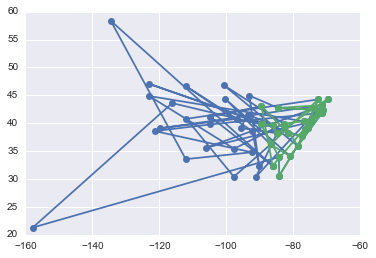

In [9]:
plot_tour(capital_cities)
plot_tour(east_cities)

So, what if we tried to enumerate them and find the shortest tour? We know that will be too many, but let's plot a few. We'll do this by making a copy and shuffling it repeatedly.

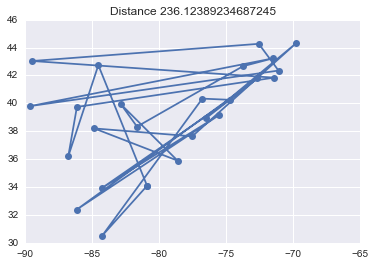

In [10]:
tours = []
numtours = 30
for i in range(numtours):
    tour = east_cities.copy()
    random.shuffle(tour)
    tours.append(tour)
def plotone(i=0):
    tour = tours[i]
    plot_tour(tour)
    plt.title('Distance {d}'.format(d=tour_dist(tour)))
interact(plotone,i=(0,numtours-1))

Or, for the whole US

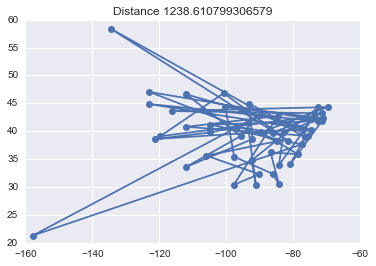

In [11]:
tours = []
numtours = 30
for i in range(numtours):
    tour = capital_cities.copy()
    random.shuffle(tour)
    tours.append(tour)
def plotone(i=0):
    tour = tours[i]
    plot_tour(tour)
    plt.title('Distance {d}'.format(d=tour_dist(tour)))
interact(plotone,i=(0,numtours-1))

Now let's try simulated annealing

In [12]:
def neighbor(tour):
    neighbor = tour.copy()
    i,j = random.randrange(0,len(tour)), random.randrange(0,len(tour))
    neighbor[i],neighbor[j] = neighbor[j],neighbor[i]
    return neighbor

In [13]:
def anneal(tour,numsteps,temp):
    results = [(tour,tour_dist(tour))]
    for i in range(numsteps):
        nb = neighbor(tour)
        d1, d2 = tour_dist(tour), tour_dist(nb)
        prob_accept = np.exp((d1 - d2) / temp(i,numsteps))
        if np.random.rand() < prob_accept:
            tour = nb
            d1,d2 = d2,d1
        results.append((tour,d1))
    return results

### What to use for temperature?

Most of the 'magic' happens by defining a "Temperature schedule" i.e. how exactly we should anneal. Remember, we need to start at a high temperature and move to a low temperature. The definition of "high" temperature will depend on the total distance we're measuring. For the East coast states, maybe 25 is a good "high" temperature. For the whole country, maybe 1000 is a good max temp.

In [14]:
# Let's drop linearly
def linear_temp(i,numsteps,maxtemp=25):
    return maxtemp*(numsteps-i)/numsteps

def one_over_x_temp(i,numsteps,maxtemp=25):
    return maxtemp*(1/(i+1))

## East Coast cities

We know that raw enumeration will take us something like the age of the universe. How about the world's simplest simulated annealing? Let's try 10000 trials using a linear temp.

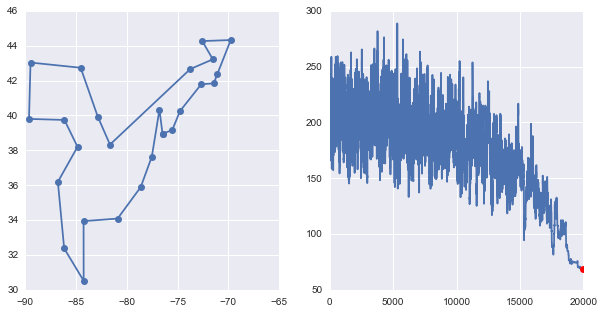

In [15]:
tour = east_cities.copy()
numtrials = 20000
results = anneal(tour,numtrials,temp=linear_temp)
def vis(i=0):
    fig = plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plot_tour(results[i][0])
    plt.subplot(1,2,2)
    plt.plot([r[1] for r in results])
    plt.plot([i], results[i][1], 'ro')
interact(vis,i=(0,numtrials-1))

Great! In a relatively short amount of time, we found a good path! 

What about using all of the cities?

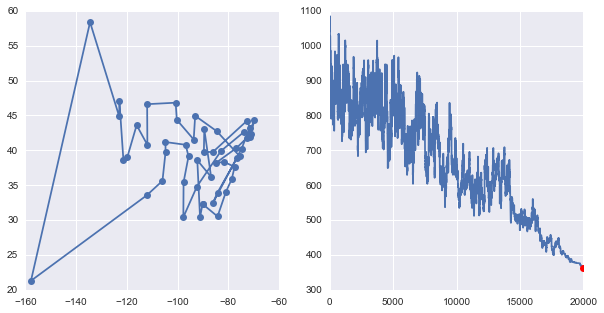

In [19]:
tour = capital_cities.copy()
numtrials = 20000
results = anneal(tour,numtrials,temp=linear_temp)
def vis(i=0):
    fig = plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plot_tour(results[i][0])
    plt.subplot(1,2,2)
    plt.plot([r[1] for r in results])
    plt.plot([i], results[i][1], 'ro')
interact(vis,i=(0,numtrials-1))

That's not perfect, but it's shockingly good given how long we ran the code! We might want to change our temperature schedule. Here's using $1/x$

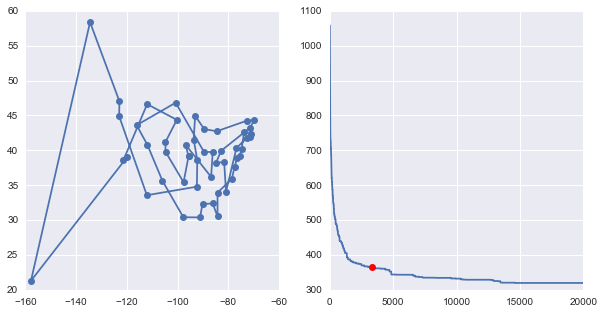

In [16]:
tour = capital_cities.copy()
numtrials = 20000
results = anneal(tour,numtrials,temp=one_over_x_temp)
def vis(i=0):
    fig = plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plot_tour(results[i][0])
    plt.subplot(1,2,2)
    plt.plot([r[1] for r in results])
    plt.plot([i], results[i][1], 'ro')
interact(vis,i=(0,numtrials-1))

You can see that this schedule spends far less time sampling at high temperatures. As you can see by the end state, though, it's probably a bit too aggressive for the problem at hand. We might thus be tempted to use some sort of combination schedule, like

In [21]:
def combo_temp(i,numsteps,maxtemp=25):
    if i < numsteps/2:
        return linear_temp(i,numsteps,maxtemp)
    else:
        return one_over_x_temp(i,numsteps,maxtemp)

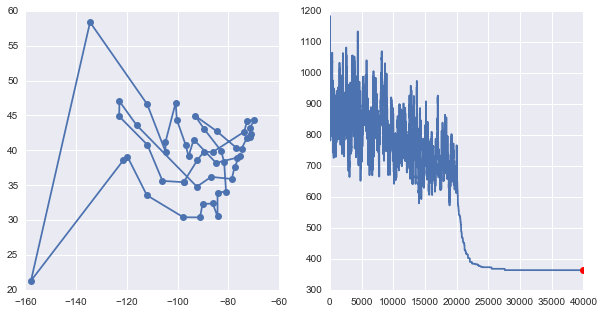

In [22]:
tour = capital_cities.copy()
numtrials = 40000
results = anneal(tour,numtrials,temp=combo_temp)
def vis(i=0):
    fig = plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plot_tour(results[i][0])
    plt.subplot(1,2,2)
    plt.plot([r[1] for r in results])
    plt.plot([i], results[i][1], 'ro')
interact(vis,i=(0,numtrials-1))

That's also far from perfect. In general, you can see that monkeying around with the temperature schedule is fairly key to these sorts of applications.

In class, we played around with different temperatures, etc. Have fun!